In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import time
import copy
import glob

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [4]:
data_path = './output_modified/train'
transform = transforms.Compose(
                [
#                     transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                ])
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

print(len(train_loader))

24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
tensor(3)


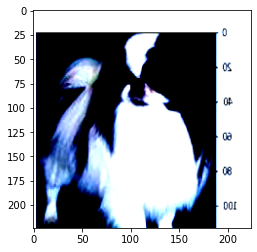

In [6]:
batch = next(iter(train_loader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [7]:
resnet18 = models.resnet18(pretrained=True)

In [8]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
resnet18.fc = nn.Linear(512, 10)

In [10]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

In [14]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_train=True):
    since = time.time()
    
    acc_history = []
    loss_history = []

    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), os.path.join('./working', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history, loss_history

In [15]:
# Here we only want to update the gradient for the classifier layer that we initialized.
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train model
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/24
----------
Loss: 1.2426 Acc: 0.5911

Epoch 1/24
----------
Loss: 0.8919 Acc: 0.6969

Epoch 2/24
----------
Loss: 0.8152 Acc: 0.7172

Epoch 3/24
----------
Loss: 0.7287 Acc: 0.7564

Epoch 4/24
----------
Loss: 0.7850 Acc: 0.7348

Epoch 5/24
----------
Loss: 0.7526 Acc: 0.7446

Epoch 6/24
----------
Loss: 0.6581 Acc: 0.7792

Epoch 7/24
----------
Loss: 0.6448 Acc: 0.7871

Epoch 8/24
----------
Loss: 0.6026 Acc: 0.7890

Epoch 9/24
----------
Loss: 0.5794 Acc: 0.8021

Epoch 10/24
----------
Loss: 0.5540 Acc: 0.8125

Epoch 11/24
----------
Loss: 0.5859 Acc: 0.8054

Epoch 12/24
----------
Loss: 0.5359 Acc: 0.8197

Epoch 13/24
----------
Loss: 0.5273 Acc: 0.8158

Epoch 14/24
----------
Loss: 0.5983 Acc: 0.8014

Epoch 15/24
----------
Loss: 0.5027 Acc: 0.8250

Epoch 16/24
----------
Loss: 0.4756 Acc: 0.8341

Epoch 17/24
----------
Loss: 0.4514 Acc: 0.8485

Epoch 18/24
----------
Loss: 0.4771 Acc: 0.8341

Epoch 19/24
----------
Loss: 0.4752 Acc: 0.8393

Epoch 20/24
----------
Loss: 0

In [25]:
test_path = './output_modified/test'
transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=False
)

print(len(test_loader))

4


In [33]:
def eval_model(model, dataloaders, device):
    since = time.time()
    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./working/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [34]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./working/00.pth', './working/01.pth', './working/02.pth', './working/03.pth', './working/04.pth', './working/05.pth', './working/06.pth', './working/07.pth', './working/08.pth', './working/09.pth', './working/10.pth', './working/11.pth', './working/12.pth', './working/13.pth', './working/14.pth', './working/15.pth', './working/16.pth', './working/17.pth', './working/18.pth', './working/19.pth', './working/20.pth', './working/21.pth', './working/22.pth', './working/23.pth', './working/24.pth']
Loading model ./working/00.pth
Acc: 0.4975

Loading model ./working/01.pth
Acc: 0.7065

Loading model ./working/02.pth
Acc: 0.5721

Loading model ./working/03.pth
Acc: 0.7015

Loading model ./working/04.pth
Acc: 0.6418

Loading model ./working/05.pth
Acc: 0.6567

Loading model ./working/06.pth
Acc: 0.7214

Loading model ./working/07.pth
Acc: 0.7065

Loading model ./working/08.pth
Acc: 0.6617

Loading model ./working/09.pth
Acc: 0.7463

Loading model ./working/10.pth
Acc: 0.7413

Loa

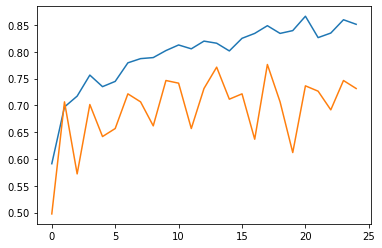

In [35]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

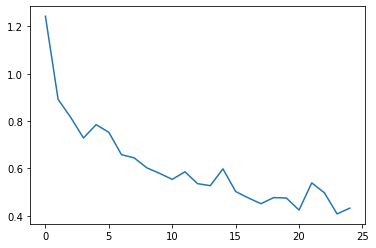

In [36]:
plt.plot(train_loss_hist)
plt.show()